In [1]:
import os
from pathlib import Path
import torch
import json
from datasets import load_dataset
import dotenv
from transformers import AutoTokenizer
from transformer_lens.utils import tokenize_and_concatenate
import tqdm
import torch
import matplotlib.pyplot as plt
import shutil
import torch.nn.functional as F

# Load our own imports, etc...
from sans_sae_lib.utils import plot_cosine_kernel, plot_all_nc2_top_pcs, plot_all_nc2_top_pcs_errs
from sans_sae_lib.schemas import ExtractedActivations, FlattenedExtractedActivations
from sans_sae_main import ResidAndLn2Comparer

"""
TODO what remains to be done:
1. Fix the fucking bugs (what happened? where did we go wrong?)
2. Enable larger batch sizes
3. Be able to fetch the relevant token activations or something like that
"""

dotenv.load_dotenv()
assert "CUDA_VISIBLE_DEVICES" in os.environ, "CUDA_VISIBLE_DEVICES is not set"
assert len(os.environ["CUDA_VISIBLE_DEVICES"].strip()) > 0, "CUDA_VISIBLE_DEVICES is empty"

print("="*50 + " [Loading Dataset] " + "="*50) # DEBUG
# dataset = load_dataset("openwebtext", split="train", trust_remote_code=True)
dataset = load_dataset("stas/openwebtext-10k", split="train", trust_remote_code=True) # Smaller version
tokenizer = AutoTokenizer.from_pretrained("gpt2")
token_dataset = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=tokenizer,  # type: ignore
    streaming=True,
    # NOTE: all these have context 128
    max_length=128, #sae.cfg.context_size,
    add_bos_token=True, #sae.cfg.prepend_bos,
)
print("="*50 + " [Loading Model] " + "="*50) # DEBUG

/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


================================================== [Loading Dataset] ==================================================
================================================== [Loading Model] ==================================================


In [2]:
# assert isinstance(token_dataset, torch.Tensor), f"token_dataset is not a torch.Tensor, it is a {type(token_dataset)}"
dataset_size = 650 # Seems kind of nonlinear in memory usage wth?? TODO(Adriano) please get more tokens
tokens = token_dataset[:dataset_size]['tokens']
dataset_length = tokens.shape[0]
sequence_length = tokens.shape[1]
assert isinstance(tokens, torch.Tensor)
tokens = tokens.to("cuda")
tokens_is_special_token_mask = (tokens == tokenizer.bos_token_id) | (tokens == tokenizer.eos_token_id)
_ = tokens_is_special_token_mask.sum() .item()
# assert _ == tokens.shape[-1], f"Found {_} eos/bos tokens but have total {tokens.shape}" # will fail with a number slightly above it looks like?
tokens_is_special_token_mask = tokens_is_special_token_mask.flatten()
print(tokens_is_special_token_mask.shape)

torch.Size([83200])


In [4]:
from typing import Optional
import pydantic
from jaxtyping import Float, Int, Bool
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint
import functools as Ft
def collect_activations_hook(
        # Input
        activation: torch.Tensor,
        # HTF thing
        hook: HookPoint,
        # We will be saving to a tensor
        activations_save_loc: torch.Tensor,
         # Pass these below for sanity t esting
        left: int,
        right: int,
        model_dim: int,
        seq_len: int,
        hook_idx: int,
    ):
    """
    A simple hook function to used in `collect_all_activations` to save a buncha activations.
    """
    # Sanity check activations
    assert activation.ndim == 3, f"activation.ndim = {activation.ndim}" # fmt: skip
    assert activation.shape[0] == right - left, f"activation.shape[0] = {activation.shape[0]}, right - left = {right - left}" # fmt: skip
    assert activation.shape[1] == seq_len, f"activation.shape[1] = {activation.shape[1]}, model_seq_size = {seq_len}" # fmt: skip
    assert activation.shape[2] == model_dim, f"activation.shape[2] = {activation.shape[2]}, model_dim = {model_dim}" # fmt: skip

    # Sanity check outputs
    assert activations_save_loc.ndim == 4
    assert 0 <= hook_idx < activations_save_loc.shape[0]
    assert 0 <= left < right <= activations_save_loc.shape[1]
    assert 0 <= activation.shape[1] == activations_save_loc.shape[2]
    assert 0 <= activation.shape[2] == activations_save_loc.shape[3]

    # Store SAE IO
    activations_save_loc[hook_idx, left:right, :, :] = activation.detach().cpu()
    return activation


model = HookedTransformer.from_pretrained("gpt2")
model = model.to("cuda")
model.eval()
layer = 6
sans = torch.rand(1).item() * 9999999
d_model = 768
buffer = (torch.ones(*(list(tokens.shape) + [d_model])) * sans).cuda().unsqueeze(0)
assert torch.all(sans == buffer).item()
with torch.no_grad():
    model.run_with_hooks(tokens, stop_at_layer=layer+1, fwd_hooks=[
            (
                f"blocks.{layer}.hook_resid_pre",
                Ft.partial(
                    collect_activations_hook,
                    activations_save_loc=buffer,
                    left=0,
                    right=tokens.shape[0],
                    model_dim=d_model,
                    seq_len=tokens.shape[1],
                    hook_idx=0,
                )
            )
        ]
    ) # Halfway through ay lmao
assert not torch.any(sans == buffer).item()
activations = buffer.squeeze(0)
print(activations.shape)
activations = activations.reshape(-1, activations.shape[-1])
print(activations.shape)
assert activations.shape[:-1] == tokens_is_special_token_mask.shape
selection_mask = ~tokens_is_special_token_mask
# activations = activations[selection_mask]
# print(activations.shape) # We can do this later

class Activations(pydantic.BaseModel):
    model_config = pydantic.ConfigDict(arbitrary_types_allowed=True)
    # Activations
    activations: torch.Tensor # Float[torch.Tensor, "batch sequence d_model"]
    latents: Optional[torch.Tensor] = None # Float[torch.Tensor, "batch sequence d_latent"]
    # Selection mask is basically used to exclude special tokens
    selection_mask: torch.Tensor # Bool[torch.Tensor, "batch sequence"]
    tokens: torch.Tensor # Int[torch.Tensor, "batch sequence"]
    unflat_shape: tuple[int, int, int]
    hook_point: str

# print(activations)

activations

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
torch.Size([650, 128, 768])
torch.Size([83200, 768])


tensor([[-4.8053, -5.0082, -4.2213,  ..., -3.4563, -3.5408, -4.0276],
        [-2.4515, -1.0372, -0.6920,  ...,  0.2618, -3.5957,  0.9457],
        [ 1.7863,  2.6986,  0.9424,  ...,  0.6481,  0.0712, -3.9387],
        ...,
        [ 1.7389,  1.4884,  0.7000,  ...,  1.3012, -1.1743,  0.1342],
        [-1.8613,  0.9860,  0.7082,  ...,  0.3154, -3.0795, -0.2072],
        [ 0.2356, -1.1265, -1.9708,  ..., -0.6192, -3.9336,  0.8299]],
       device='cuda:0')

In [7]:
import gc
import torch.nn.functional as F
from sae_lens import SAE
# try:
#     del activations_obj
#     gc.collect()
#     torch.cuda.empty_cache()
# except NameError:
#     print("activations_obj not found")
# Now we can use activations to do our EDA of the SAE features...
# def load_jbloom_gpt2_saes(self, sae_release: str = "gpt2-small-res-jb"):
#     self.saes = []
#     self.sae_cfg_dicts = []
#     self.sae_sparsities = []
#     for layer in range(self.model.cfg.n_layers):
#         sae, cfg_dict, sparsity = SAE.from_pretrained(
#             release = sae_release,
#             sae_id = f"blocks.{layer}.hook_resid_pre",
#             device = self.device
#         )
#         sae.eval()
#         self.saes.append(sae)
#         self.sae_cfg_dicts.append(cfg_dict)
#         self.sae_sparsities.append(sparsity)
sae, _, _ = SAE.from_pretrained(
    release = "gpt2-small-res-jb",
    # NOTE: it looks like `layer` is the best index here....
    sae_id = f"blocks.{layer}.hook_resid_pre",
    device = "cuda"
)
sae.eval()
decoded = sae(activations)
mse = F.mse_loss(decoded, activations)
percent_norm_error = ((decoded - activations).norm(dim=-1) / activations.norm(dim=-1)).mean()
# NOTE we are doing PER neuron here... not sure if that's the best? just wanna make sure it's not super high tbh
# TODO(Adriano) this FVU seems really bad but norm error is not thatttt bad???
# NOTE above it looks like I'm probably doing this right so eh...
fvu = ((decoded-activations).pow(2) / (activations - activations.mean(dim=0, keepdim=True)).pow(2)).mean()
fvu_norm = ((decoded-activations).pow(2).sum(dim=-1) / (activations - activations.mean(dim=0, keepdim=True)).pow(2).sum(dim=-1)).mean()
print(f"mse={mse.item()}")
print(f"(mean) percent_norm_error={percent_norm_error.item()}")
print(f"(mean) fvu={fvu.item()}")
print(f"(mean) fvu_norm={fvu_norm.item()}") # A lot better huh wth?? is this a convexity thing?
del fvu, fvu_norm, mse, percent_norm_error, decoded
gc.collect()
torch.cuda.empty_cache()
# SAE latents importantly have the same shape as the activations

/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


mse=0.5339547991752625
(mean) percent_norm_error=0.24623841047286987
(mean) fvu=1308739.125
(mean) fvu_norm=0.10558437556028366


In [5]:
# SAE latents importantly have the same shape as the activations
print(activations)
latents = sae.encode(activations)
# print(torch.all(latents == 0).item())
# raise NotImplementedError("Not implemented")
assert latents.shape[0] == activations.shape[0]
d_latent = latents.shape[-1]
print(f"d_latent={d_latent}")

# Once we have latents, etc... we are basically good to go AFAIK
# activations_obj = Activations(
#     activations=activations.detach().clone(),
#     decoded=decoded.detach().clone(),
#     # latents=latents.detach().clone(),
#     selection_mask=selection_mask.detach().clone(),
#     tokens=tokens.detach().clone(),
#     unflat_shape=[tokens.shape[0], tokens.shape[1], d_model],
#     hook_point=f"blocks.{layer}.hook_resid_pre",
# )
# del activations, decoded, selection_mask, latents
gc.collect()
torch.cuda.empty_cache()
# print("Created activations_obj")

tensor([[-4.8053, -5.0082, -4.2213,  ..., -3.4563, -3.5408, -4.0276],
        [-2.4515, -1.0372, -0.6920,  ...,  0.2618, -3.5957,  0.9457],
        [ 1.7863,  2.6986,  0.9424,  ...,  0.6481,  0.0712, -3.9387],
        ...,
        [ 1.7389,  1.4884,  0.7000,  ...,  1.3012, -1.1743,  0.1342],
        [-1.8613,  0.9860,  0.7082,  ...,  0.3154, -3.0795, -0.2072],
        [ 0.2356, -1.1265, -1.9708,  ..., -0.6192, -3.9336,  0.8299]],
       device='cuda:0')
d_latent=24576


In [6]:
# Not really used
#
#
# cmport json
# assert latents.min() >= 0.0
# n_dead = (latents == 0.0).sum()
# n_tot = latents.numel()
# # NOTE most are dead! this is basically what we want right
# print(f"n_dead={n_dead}, n_tot={n_tot}, n_dead/n_tot={n_dead/n_tot}")
# assert n_dead > 0
# n_dead_per_latent = (latents == 0.0).sum(dim=0)
# n_tot_per_latent = latents.shape[0]
# frac_dead_per_latent = n_dead_per_latent / n_tot_per_latent

# # Plot histogram of fraction of dead activations per latent
# import matplotlib.pyplot as plt
# import numpy as np

# plt.figure(figsize=(10, 6))
# plt.hist(frac_dead_per_latent.cpu().numpy(), bins=50, alpha=0.7)
# plt.xlabel('Fraction of Dead Activations')
# plt.ylabel('Count')
# plt.title('Histogram of Dead Activation Fractions per Latent')
# plt.grid(alpha=0.3)
# plt.show()

# # Calculate and print statistics
# # NOTE there seem to be no high frequency features??? All seem to be usually dead...
# stats = {
#     'max': frac_dead_per_latent.max().item(),
#     'min': frac_dead_per_latent.min().item(),
#     'mean': frac_dead_per_latent.mean().item(),
#     'median': frac_dead_per_latent.median().item(),
#     'std': frac_dead_per_latent.std().item(),
#     '25th percentile': frac_dead_per_latent.quantile(0.25).item(),
#     '75th percentile': frac_dead_per_latent.quantile(0.75).item(),
# }
# print(json.dumps(stats, indent=4))


In [7]:
# Not really used
#
# 
# # Let's understand the optimal location to binarize (zero or distortion minimizer: mean)
# # NOTE we should do this CONDITIONING on the case where the we assume the latents are non-zero
# latents_n_zero = (latents != 0).sum(dim=0)
# latents_means = latents.sum(dim=0) / latents_n_zero
# # 2nd moment - exp sq.
# latents_stdevs = (latents.pow(2).sum(dim=0) / latents_n_zero) - latents_means.pow(2)
# print("latents_means[:10]:", latents_means[:10])
# print("latents_stdevs[:10]:", latents_stdevs[:10])
# latents_maxes = latents.max(dim=0).values
# # latents_mins = latents.min(dim=0).values # eh ignore mins for now??
# # print(latents_means.shape)
# for arr, arr_name in zip(
#     [
#         latents_means,
#         latents_stdevs,
#         latents_maxes,
#         # latents_mins
#     ],
#     [
#         "means",
#         "stdevs",
#         "maxes",
#         # "mins"
#     ]
# ):
#     # Plot histogram of latent means
#     plt.figure(figsize=(10, 6))
#     plt.hist(arr.detach().cpu().numpy(), bins=50, alpha=0.7)
#     plt.title(f'Histogram of {arr_name} per Latent')
#     plt.grid(alpha=0.3)
#     plt.show()

#     # Calculate and print statistics for latent means
#     latent_mean_stats = {
#         'max': arr[~arr.isnan()].max().item(),
#         'min': arr[~arr.isnan()].min().item(),
#         'mean': arr[~arr.isnan()].mean().item(),
#         'median': arr[~arr.isnan()].median().item(),
#         'std': arr[~arr.isnan()].std().item(),
#         '25th percentile': torch.quantile(arr[~arr.isnan()], 0.25).item(),
#         '75th percentile': torch.quantile(arr[~arr.isnan()], 0.75).item(),
#     }
#     print(f"Statistics for latents {arr_name} (not nan):")
#     print(json.dumps(latent_mean_stats, indent=4))


In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [7]:

# Let's look at the top K lowest variance (when non-zero) latents
K = latents.shape[1]
def get_top_k_binarizeable_latents(latents: torch.Tensor, K: int) -> torch.Tensor:
    latents_n_zero = (latents != 0).sum(dim=0)
    latents_means = latents.sum(dim=0) / latents_n_zero
    latents_stdevs = (latents.pow(2) / latents_n_zero).sum(dim=0) - latents_means.pow(2)
    top_k_latents = latents_stdevs.argsort()[:K]
    top_k_latents_stdevs = latents_stdevs[top_k_latents].detach().requires_grad_(False)
    top_k_latents_means = latents_means[top_k_latents].detach().requires_grad_(False)
    return top_k_latents, top_k_latents_stdevs, top_k_latents_means

print(latents.shape)
print(selection_mask.shape)
top_k_latents, top_k_latents_stdevs, top_k_latents_means = get_top_k_binarizeable_latents(
    latents[selection_mask, ...][:100, ...], K
)

print(latents.shape) # DEBUG

print("top_k_latents:", top_k_latents)
print("top_k_latents_stdevs:", top_k_latents_stdevs)
print("top_k_latents_means:", top_k_latents_means)
# raise NotImplementedError("Not implemented")

torch.Size([83200, 24576])
torch.Size([83200])
torch.Size([83200, 24576])
top_k_latents: tensor([    6,    31,    38,  ..., 24573, 24574, 24575], device='cuda:0')
top_k_latents_stdevs: tensor([0., 0., 0.,  ..., nan, nan, nan], device='cuda:0')
top_k_latents_means: tensor([ 4.9195,  0.5902, 12.6890,  ...,     nan,     nan,     nan],
       device='cuda:0')


In [ ]:
# activations_obj.latents = None # TODO(Adriano) instead of doing encoding we could just use the latents tbh
gc.collect()
torch.cuda.empty_cache()
activations_obj = Activations(
    activations=activations.detach().clone(),
    # latents=latents.detach().clone(), # naw
    selection_mask=selection_mask.detach().clone(),
    tokens=tokens.detach().clone(),
    unflat_shape=[tokens.shape[0], tokens.shape[1], d_model],
    hook_point=f"blocks.{layer}.hook_resid_pre",
)
import pydantic
import gc
import tqdm
from typing import List
import torch.nn as nn
class BinarizedSAE(nn.Module):
    """
    The idea here is pretty simple: we will simply set the latents
    to the value we pass in here at the indices specified. This can be called
    with differnet indices to see the impact of binarizing multiple latents
    at once or every one individually.
    """
    def __init__(
            self,
            sae: SAE,
            binarize_indices: torch.Tensor,
            binarize_value: torch.Tensor,
        ):
        super().__init__()
        self.sae = sae
        self.binarize_indices = binarize_indices
        self.binarize_value = binarize_value
        assert self.binarize_indices.shape == self.binarize_value.shape

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 2 or x.ndim == 3
        latents = self.sae.encode(x)
        assert latents.shape[0] == x.shape[0]
        assert latents.ndim == x.ndim
        # NOTE: you can use empty k to simulate no binarization
        if self.binarize_indices.numel() > 0:
            if x.ndim == 2:
                is_nonzero = ~(latents[:, self.binarize_indices] == 0)
                insertion = is_nonzero * self.binarize_value
                latents[:, self.binarize_indices] = insertion
            else:
                is_nonzero = ~(latents[:, :, self.binarize_indices] == 0)
                insertion = is_nonzero * self.binarize_value
                latents[:, :, self.binarize_indices] = insertion
        return self.sae.decode(latents)


# top_k_binarized_sae = BinarizedSAE(sae, top_k_latents, top_k_latents_means)
# top_k_binarized_sae.eval()

class ReconsttructionMetricsSingle(pydantic.BaseModel):
    fvu: float
    fvu_norm: float
    mse: float
    percent_norm_error: float
    loss: float
class ReconsttructionMetricsSweep(pydantic.BaseModel):
    fvu: List[float]
    fvu_norm: List[float]
    mse: List[float]
    percent_norm_error: List[float]
    loss: List[float]

def get_tl_loss(
    model: HookedTransformer,
    decoded: torch.Tensor,
    tokens: torch.Tensor,
    hook_point: str,
) -> float:
    def replace_hook_point(activations: torch.Tensor, hook: HookPoint) -> torch.Tensor:
        assert activations.ndim == 3, f"activations.shape={activations.shape}"
        # eh
        # assert decoded.shape == activations.shape, f"decoded.shape={decoded.shape}, activations.shape={activations.shape}" # fmt: skip
        return decoded.reshape(activations.shape) # Replace the activations
    with torch.no_grad():
        return model.run_with_hooks(
            tokens,
            fwd_hooks=[(hook_point, replace_hook_point)],
            return_type="loss"
        ).detach().item() # NOTE: detach seemingly is necessary to avoid memory leak?!
# print("Testing get_tl_loss") # DEBUG
# og_loss = get_tl_loss(model, sae, tokens, f"blocks.{layer}.hook_resid_pre")
# print(f"og_loss={og_loss}")

def evaluate_autoencoder_reconstruction(
    autoencoder: nn.Module,
    activations_obj: Activations,
    printout: bool = False,
    keep_special_tokens: bool = True,
) -> ReconsttructionMetricsSingle:
    """
    Just generalizes the code above to basically evaluate the SAE reconstruction error
    via various metrics to tell if the binarized SAE is OBVIOUSLY worse than the non-binarized
    version.

    NOTE: use autoencoder None to just use the activations directly
    """
    # TODO(Adriano) we should use the latents....
    assert activations_obj.activations.ndim == 2
    activations = activations_obj.activations
    selection_mask = activations_obj.selection_mask
    tokens = activations_obj.tokens
    hook_point = activations_obj.hook_point
    decoded = activations
    if autoencoder is not None:
        decoded = autoencoder(activations)
        if keep_special_tokens:
            decoded[~selection_mask, ...] = activations[~selection_mask, ...]
        
    assert decoded.shape == activations.shape
    mse = F.mse_loss(decoded, activations)
    percent_norm_error = ((decoded - activations).norm(dim=-1) / activations.norm(dim=-1)).mean()
    # NOTE we are doing PER neuron here... not sure if that's the best? just wanna make sure it's not super high tbh
    # TODO(Adriano) this FVU seems really bad but norm error is not thatttt bad???
    # NOTE above it looks like I'm probably doing this right so eh...
    fvu = ((decoded-activations).pow(2) / (activations - activations.mean(dim=0, keepdim=True)).pow(2)).mean()
    fvu_norm = ((decoded-activations).pow(2).sum(dim=-1) / (activations - activations.mean(dim=0, keepdim=True)).pow(2).sum(dim=-1)).mean()
    # Final loss is NLL of the correct token prediction
    with torch.no_grad():
        assert decoded.shape == activations.shape
        loss = get_tl_loss(model, decoded, tokens, hook_point)
    if printout:
        print(f"mse={mse.item()}")
        print(f"(mean) percent_norm_error={percent_norm_error.item()}")
        print(f"(mean) fvu={fvu.item()}")
        print(f"(mean) fvu_norm={fvu_norm.item()}") # A lot better huh wth?? is this a convexity thing?
    return ReconsttructionMetricsSingle(
        fvu=fvu.item(),
        fvu_norm=fvu_norm.item(),
        mse=mse.item(),
        percent_norm_error=percent_norm_error.item(),
        loss=loss,
    )

def sweep_first_ks(
    # Write INTO here
    top_k_indices: torch.Tensor,
    # Write THIS value
    top_k_values: torch.Tensor,
    # Test on these activations to get metrics
    activations_obj: Activations,
    ks: Optional[List[int]] = None,
) -> ReconsttructionMetricsSweep:
    activations = activations_obj.activations.detach() # ??
    fvus, fvu_norms, mses, percent_norm_errors, losses = [], [], [], [], []
    ks = tqdm.trange(-1, top_k_indices.shape[0] + 1) if ks is None else tqdm.tqdm(ks)
    for k in ks:
        binarized_sae = BinarizedSAE(sae, top_k_indices[:k], top_k_values[:k]) if k >= 0 else None
        metrics = evaluate_autoencoder_reconstruction(binarized_sae, activations_obj)
        # Append to our lists
        fvus.append(metrics.fvu)
        fvu_norms.append(metrics.fvu_norm)
        mses.append(metrics.mse)
        percent_norm_errors.append(metrics.percent_norm_error)
        losses.append(metrics.loss)
        # ...
        torch.cuda.empty_cache()
        gc.collect()
    # Return our metrics
    return ReconsttructionMetricsSweep(
        fvu=fvus,
        fvu_norm=fvu_norms,
        mse=mses,
        percent_norm_error=percent_norm_errors,
        loss=losses,
    )

import math
gc.collect()
torch.cuda.empty_cache()
# evaluate_autoencoder_reconstruction(sae, activations)
# evaluate_autoencoder_reconstruction(top_k_binarized_sae, activations)
ks = sorted(
    list(
        set(
            [
                min(math.ceil(1.5**i), top_k_latents.shape[0])
                for i in range(100)
            ]
        ),
    ),
)
print(json.dumps(ks, indent=4))
sweeped_first_K = sweep_first_ks(
    top_k_latents,
    top_k_latents_means,
    activations_obj,
    ks=ks,
)
print(sweeped_first_K.model_dump_json(indent=4))

[
    1,
    2,
    3,
    4,
    6,
    8,
    12,
    18,
    26,
    39,
    58,
    87,
    130,
    195,
    292,
    438,
    657,
    986,
    1478,
    2217,
    3326,
    4988,
    7482,
    11223,
    16835,
    24576
]
{
    "fvu": [
        1308738.125,
        1309495.5,
        1309622.875,
        1309623.625,
        1323849.75,
        1323799.875,
        1323835.0,
        1324152.125,
        1332593.625,
        1335647.25,
        1318795.125,
        1318594.5,
        1334091.25,
        1332233.875,
        1335475.375,
        1347753.375,
        1263465.125,
        1335697.125,
        1266253.875,
        1168334.375,
        null,
        null,
        null,
        null,
        null,
        null
    ],
    "fvu_norm": [
        0.10557272285223007,
        0.10557366162538528,
        0.10559061169624329,
        0.10559871792793274,
        0.10560503602027893,
        0.10563767701387405,
        0.10576357692480087,
        0.10590463131666183,
    

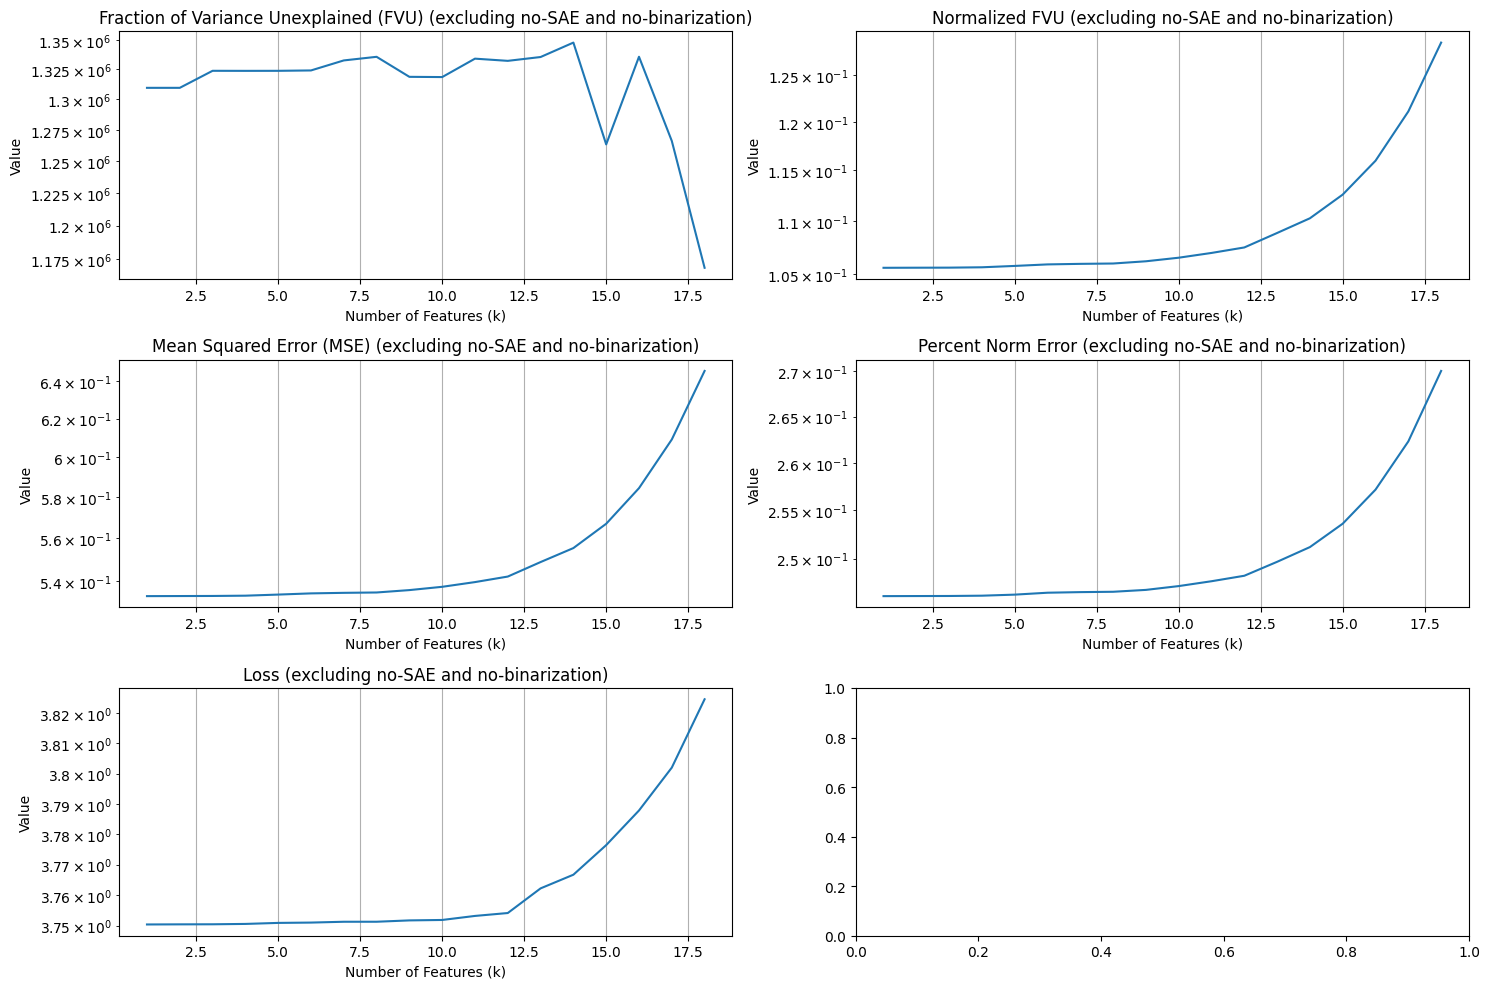

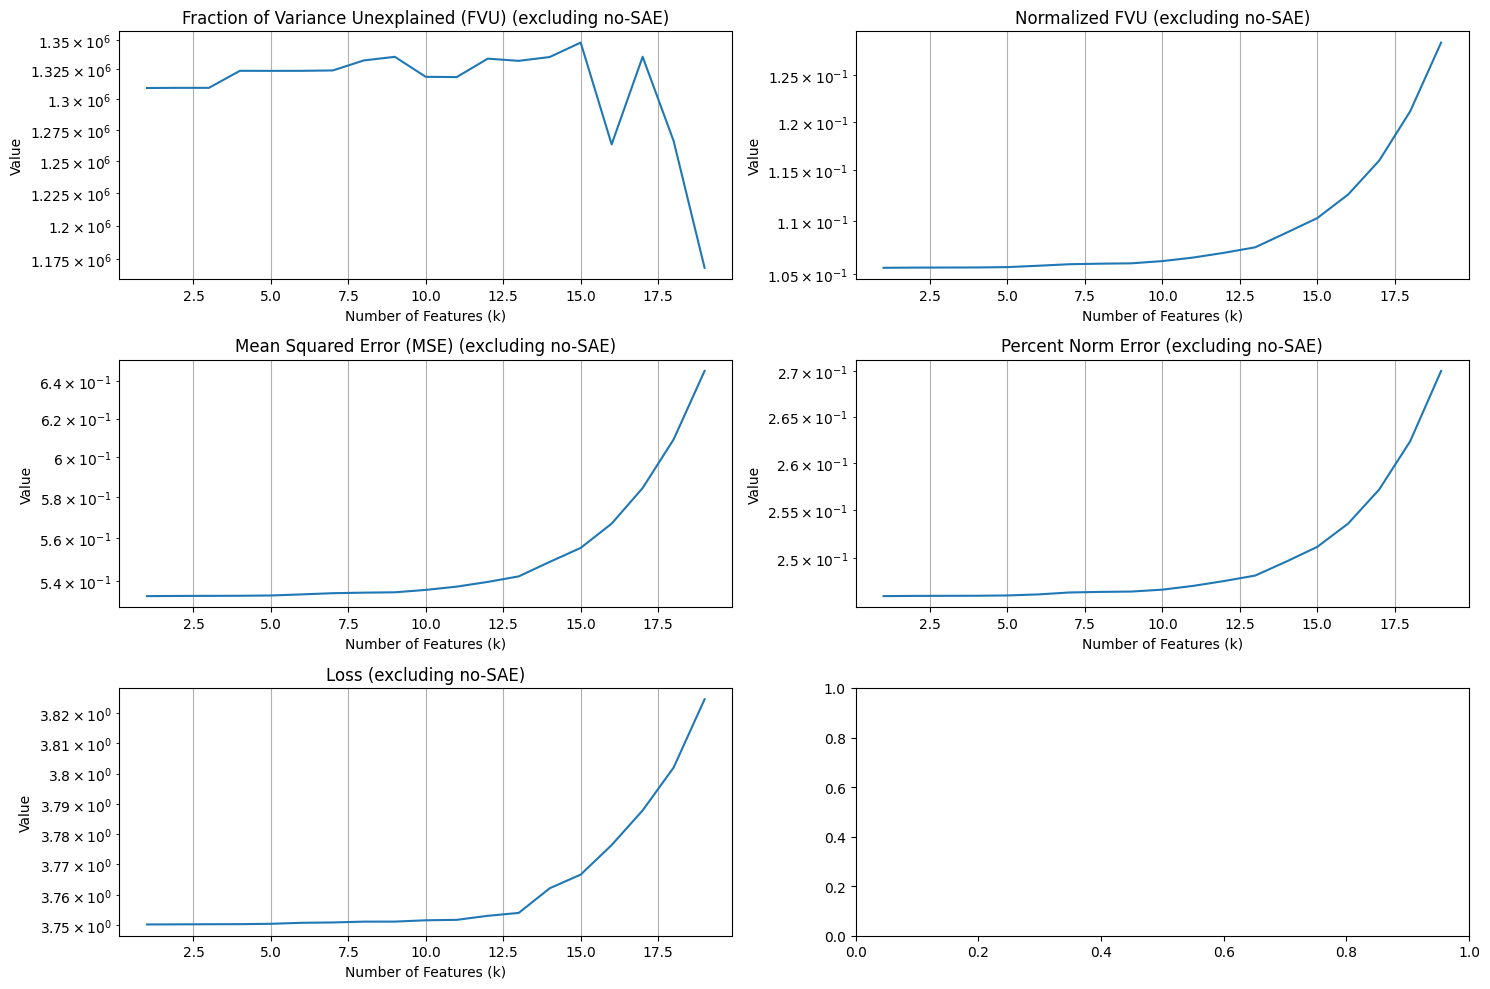

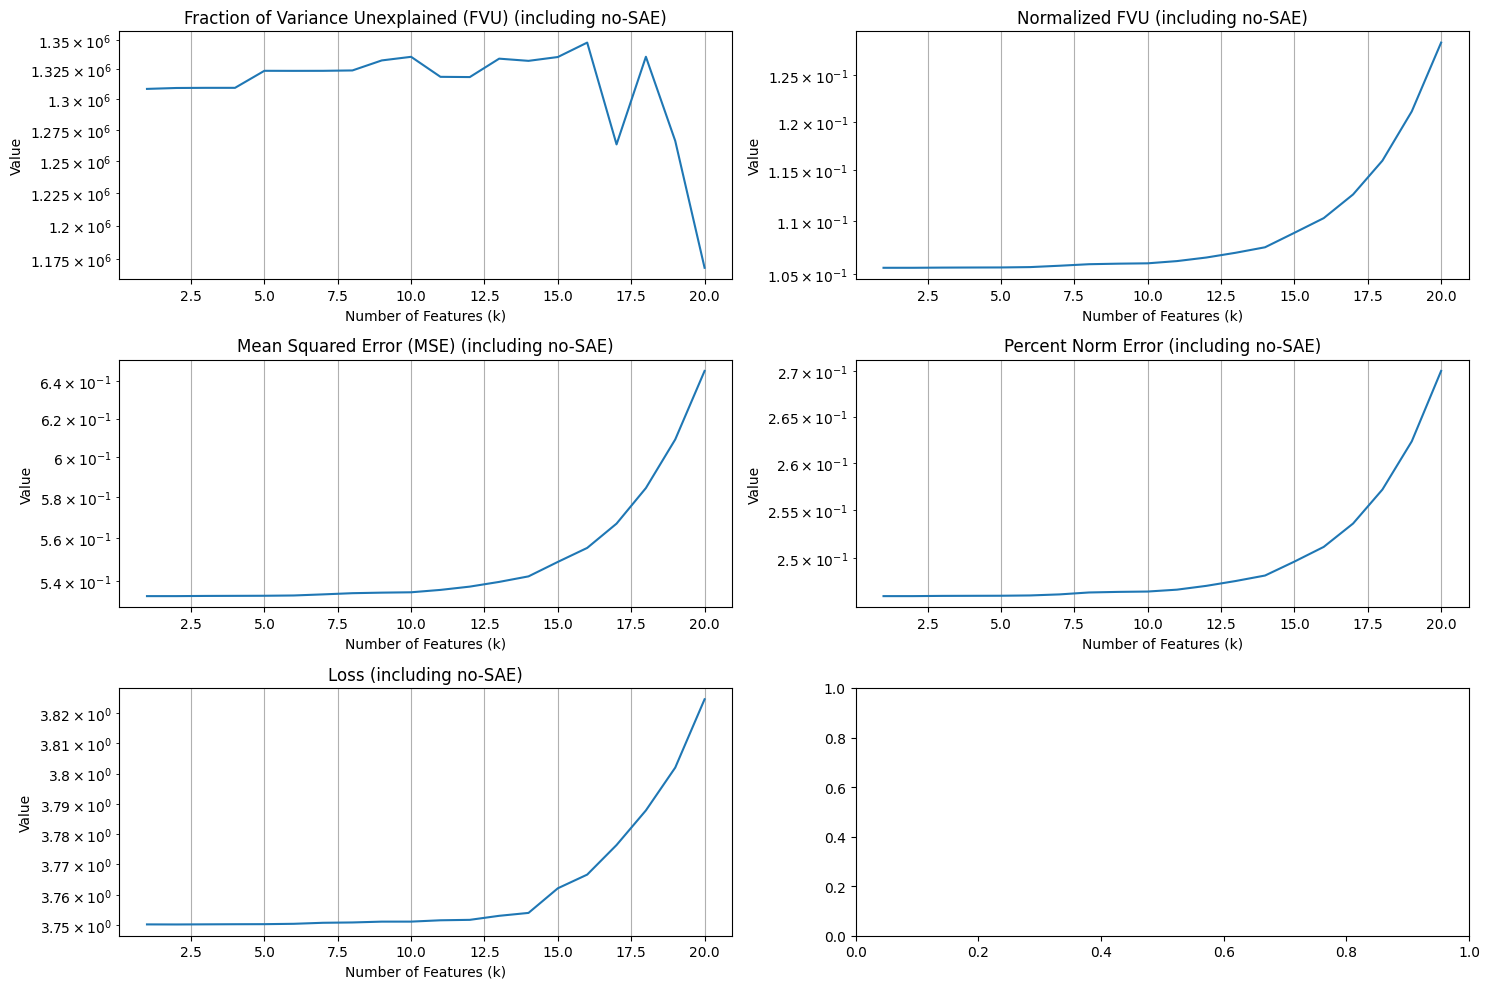

In [11]:
import matplotlib.pyplot as plt

# Plot data with appropriate titles and labels
for start_idx in [2, 1, 0]:
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    # Flatten the axes array for easier iteration
    axs = axs.flatten()
    start_idx_str = "(including no-SAE)" if start_idx == 0 else (
        "(excluding no-SAE)" if start_idx == 1 else "(excluding no-SAE and no-binarization)"
    )
    metrics = [
        (sweeped_first_K.fvu[start_idx:], f"Fraction of Variance Unexplained (FVU) {start_idx_str}"),
        (sweeped_first_K.fvu_norm[start_idx:], f"Normalized FVU {start_idx_str}"),
        (sweeped_first_K.mse[start_idx:], f"Mean Squared Error (MSE) {start_idx_str}"),
        (sweeped_first_K.percent_norm_error[start_idx:], f"Percent Norm Error {start_idx_str}"),
        (sweeped_first_K.loss[start_idx:], f"Loss {start_idx_str}")
    ]

    for i, (data, title) in enumerate(metrics):
        # Create x-axis values (1 to k)
        x = list(range(1, len(data) + 1))
        
        # Plot the data
        axs[i].plot(x, data)
        axs[i].set_title(title)
        axs[i].set_xlabel("Number of Features (k)")
        axs[i].set_ylabel("Value")
        # Log scale
        axs[i].set_yscale("log")
        # axs[i].set_xscale("log")
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


In [12]:
from transformers import PreTrainedTokenizerBase
def get_max_activating_sections(
    latents: torch.Tensor,
    tokens: torch.Tensor,
    k: int,
    tokenizer: PreTrainedTokenizerBase,
    index: int
) -> List[str]:
    # Get the top k activating tokens from the ENTIRE dataset
    assert latents.ndim == 2
    latent = latents[:, index]
    # print(latent.shape)
    top_k_indices = torch.argsort(latent, descending=True)[:k]
    assert top_k_indices.ndim == 1 and top_k_indices.shape[0] == k
    tokens_mask = torch.zeros_like(tokens, dtype=torch.bool)
    assert tokens_mask.numel() == latent.numel(), f"tokens_mask.shape={tokens_mask.shape}, latent.shape={latent.shape}"
    tokens_mask = tokens_mask.reshape(latent.shape)
    tokens_mask[top_k_indices] = True
    # Extract the "sentences" that are relevant
    tokens_mask = tokens_mask.reshape(tokens.shape)
    nonzero_batch = tokens_mask.sum(dim=1) > 0
    tokens_mask = tokens_mask[nonzero_batch, ...]
    tokens = tokens[nonzero_batch, ...]
    # Now create the strings that are relevant
    tokens_mask = tokens_mask.int()
    # TODO(Adriano) support marking all the true indices
    index_of_first_true = tokens_mask.argmax(dim=1)
    index_of_last_true = tokens_mask.size(1) - 1 - tokens_mask.flip(dims=[1]).argmax(dim=1)
    left_amt, right_amt = 10, 10
    start_idx = torch.clamp(index_of_first_true - left_amt, min=0)
    end_idx = torch.clamp(index_of_last_true + right_amt, max=tokens.size(1) - 1)
    assert torch.all(start_idx <= end_idx), f"start_idx={start_idx}, end_idx={end_idx}"
    sections: List[torch.Tensor] = []
    for i in range(tokens.shape[0]):
        ids  = tokens[i, start_idx[i]:end_idx[i]+1]
        msk  = tokens_mask[i, start_idx[i]:end_idx[i]+1]
        # toks = tokenizer.convert_ids_to_tokens([tokenizer.decode([id], skip_special_tokens=False) for id in ids])
        # marked = "".join(
        #     tok + ("*" if flag else "")
        #     for tok, flag in zip(toks, msk)
        # )
        # sections.append(f"{''.join(map(str, toks))}")
        decoded = tokenizer.decode(ids)
        important_tokens = tokenizer.decode(ids[msk])
        sections.append(f"{decoded}... {important_tokens}")
        # sections.append(tokenizer.decode(ids))
    return sections


In [13]:
tokenizer = model.tokenizer
for k in top_k_latents:
    max_activating_examples = get_max_activating_sections(
        latents,
        tokens,
        # top activating tokens overall
        k=100,
        tokenizer=tokenizer,
        # For the first latent
        index=0,
    )
    print("\n===========================\n".join(max_activating_examples))
    print("="*100)

<|endoftext|>A magazine supplement with an image of Adolf Hitler and the title 'The Unreadable Book' is pictured in Berlin. No law bans “Mein Kampf” in Germany, but the government of Bavaria, holds the copyright and guards it ferociously. (Thomas Peter/REUTERS)

The city that was the center of Adolf Hitler’s empire is littered with reminders of the Nazi past, from the bullet holes that pit the fronts of many... AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
’s role in the Bush administration was always noted, there was no mention of his ties to Ray... ���������’����������
 and found a group of people drinking alcohol. Police noted safety hazards on that visit and requested a building and...  and and and and and and and and and and found and and and and and and and and and and
In 90 of the 92 trips studied, the team det

In [14]:
# Python Example
from circuitsvis.tokens import colored_tokens
colored_tokens(["My", "tokens"], [0.123, -0.226])

In [15]:
colored_tokens(["My", "tokens"], [0.123, -0.226])

In [36]:
activations_obj.latents = None
gc.collect()
torch.cuda.empty_cache()

list(k for k, v in sae.named_parameters())
print(sae.b_dec.shape)

# TODO(Adriano) we shud also be using CSR (etc...) for does latents babyyyyy

torch.Size([768])


In [12]:
import einops
def get_tl_loss(
    model: HookedTransformer,
    decoded: torch.Tensor,
    tokens: torch.Tensor,
    hook_point: str,
) -> float:
    def replace_hook_point(activations: torch.Tensor, hook: HookPoint) -> torch.Tensor:
        assert activations.ndim == 3, f"activations.shape={activations.shape}"
        # eh
        # assert decoded.shape == activations.shape, f"decoded.shape={decoded.shape}, activations.shape={activations.shape}" # fmt: skip
        return decoded.reshape(activations.shape) # Replace the activations
    with torch.no_grad():
        return model.run_with_hooks(
            tokens,
            fwd_hooks=[(hook_point, replace_hook_point)],
            return_type="loss"
        ).detach().item() # NOTE: detach seemingly is necessary to avoid memory leak?!

# class ZeroOutSAE(nn.Module):
#     def __init__(self, sae: SAE):
#         super().__init__()
#         self.b_dec = sae.b_dec.data.detach().clone().requires_grad_(False).squeeze()
#         assert self.b_dec.ndim == 1

#     # Ay lmao
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         assert x.ndim == 2
#         batch, d_model = x.shape
#         assert d_model == self.b_dec.shape[0]
#         return einops.repeat(self.b_dec, "d_model -> batch d_model", batch=x.shape[0])


# Get the activations for testing
# our_activations = activations.reshape(-1, activations.shape[-1])[~tokens_is_special_token_mask, ...]
our_activations = activations
print(f"our_activations.shape={our_activations.shape}")
decoded = sae.b_dec.data.detach().clone().requires_grad_(False).squeeze()
decoded = einops.repeat(decoded, "d_model -> batch d_model", batch=our_activations.shape[0])
print(f"decoded.shape={decoded.shape}")
# Copy some shit to get loss
mse = F.mse_loss(decoded, our_activations)
percent_norm_error = ((decoded - our_activations).norm(dim=-1) / our_activations.norm(dim=-1)).mean()
fvu = ((decoded-our_activations).pow(2) / (our_activations - our_activations.mean(dim=0, keepdim=True)).pow(2)).mean()
fvu_norm = ((decoded-our_activations).pow(2).sum(dim=-1) / (our_activations - our_activations.mean(dim=0, keepdim=True)).pow(2).sum(dim=-1)).mean()
# Final loss is NLL of the correct token prediction
with torch.no_grad():
    for p in model.parameters():
        p.requires_grad = False
        p.grad = None
    loss = get_tl_loss(model, decoded, tokens, f"blocks.{layer}.hook_resid_pre")#.detach().requires_grad_(False).item()

print(f"mse={mse.item()}")
print(f"(mean) percent_norm_error={percent_norm_error.item()}")
print(f"(mean) fvu={fvu.item()}")
print(f"(mean) fvu_norm={fvu_norm.item()}") # A lot better huh wth?? is this a convexity thing?
print(f"loss={loss} (mean loss i.e. mean NLL)")

our_activations.shape=torch.Size([83200, 768])
decoded.shape=torch.Size([83200, 768])
mse=95.65239715576172
(mean) percent_norm_error=0.7261228561401367
(mean) fvu=732366.5
(mean) fvu_norm=0.8637902140617371
loss=9.276593208312988 (mean loss i.e. mean NLL)
